# Ideal rocket analysis

In [1]:
# this line makes figures interactive in Jupyter notebooks
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# these lines are only for helping improve the display
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['figure.dpi']= 150
plt.rcParams['savefig.dpi'] = 150

## Characteristic velocity: c*

$$
c^* = \frac{p_0 A_t}{\dot{m}} = \sqrt{\frac{R T_0}{\gamma} \left( \frac{\gamma + 1}{2} \right)^{\frac{\gamma+1}{\gamma-1}} } \;,
$$

where $p_0$ and $T_0$ are the combustion chamber pressure and temperature,
$R$ is the specific gas constant ($\mathcal{R}_u / MW$), 
and $\gamma$ is the specific heat ratio.

## Thrust coefficient

$$
\begin{align*}
C_F &= \frac{T}{p_0 A_t} = \sqrt{\frac{2\gamma^2}{\gamma-1} \left( \frac{2}{\gamma+1} \right)^{\frac{\gamma+1}{\gamma-1}} \left[1 - \left( \frac{p_e}{p_0} \right)^{\frac{\gamma-1}{\gamma}} \right] } + \frac{A_e}{A_t} \frac{p_e - p_a}{p_0} \\
&= C_F^0 + \Delta C_F \;,
\end{align*}
$$

where $T$ is thrust, $p_e$ is the nozzle exit pressure, 
$A_e$ and $A_t$ are the nozzle exit and throat areas, and $p_a$ is the ambient pressure.

## Relationships with thrust, specific impulse, and effective exhaust velocity

Using characteristic velocity ($c^*$) and thrust coefficient ($C_F$),
we can express thrust, specific impulse ($I_{\text{sp}}$), 
and effective exhause velocity ($c$):

$$
\begin{align*}
T &= \dot{m} c^* C_F \\
I_{\text{sp}} &= \frac{c^* C_F}{g_0} \\
c &= c^* C_F \;.
\end{align*}
$$

## Area ratio

The nozzle area ratio (exit area to throat area) can be determined directly 
from the nozzle pressure ratio:

$$
\frac{A_e}{A_t} = \left( \frac{2}{\gamma+1}\right)^{\frac{1}{\gamma+1}} \left( \frac{p_e}{p_0} \right)^{\frac{-1}{\gamma}} \sqrt{ \frac{\gamma-1}{\gamma+1} \left[1 - \left( \frac{p_e}{p_0}\right)^{\frac{\gamma-1}{\gamma}} \right]^{-1} }
$$

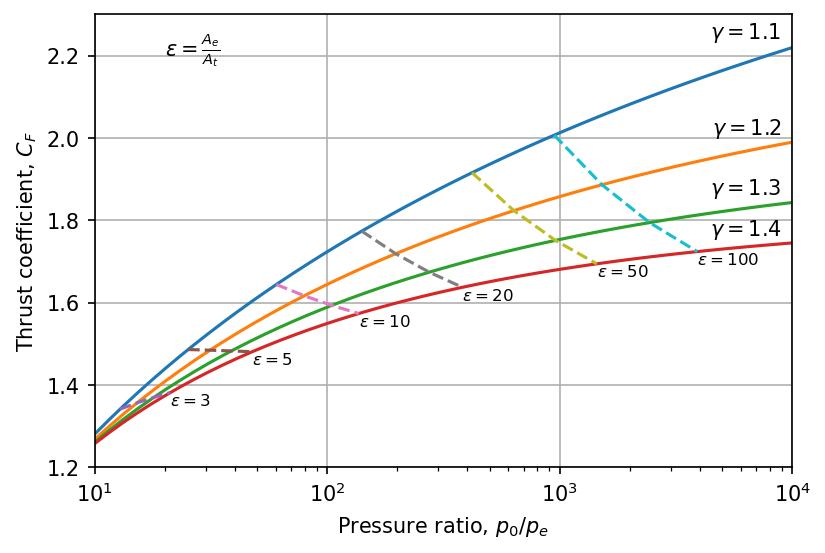

In [44]:
import numpy as np
from scipy.optimize import root_scalar

def calc_thrust_coeff(gamma, pressure_ratio):
    ''' Calculates thrust coefficient for optimum expansion (exit = ambient pressure). 
    pressure ratio: chamber / exit
    area ratio: exit / throat
    '''
    return np.sqrt(
        2 * np.power(gamma, 2) / (gamma - 1) * 
        np.power(2 / (gamma + 1), (gamma + 1)/(gamma - 1)) * 
        (1 - np.power(1.0 / pressure_ratio, (gamma - 1)/gamma))
        )

def root_area_ratio(pressure_ratio, gamma, area_ratio):
    ''' pressure ratio: chamber / exit
    area ratio: exit / throat
    '''
    return (
        area_ratio - np.power(2 / (gamma+1), 1/(gamma-1)) * 
        np.power(pressure_ratio, 1 / gamma) *
        np.sqrt((gamma - 1) / (gamma + 1) /
                (1 - np.power(1.0 / pressure_ratio, (gamma - 1)/gamma))
                )
        )

gammas = [1.1, 1.2, 1.3, 1.4]
area_ratios = [3, 5, 10, 20, 50, 100]

pressure_ratios = np.logspace(1, 4, num=50)

for gamma in gammas:
    thrust_coeffs = calc_thrust_coeff(gamma, pressure_ratios)
    
    plt.plot(pressure_ratios, thrust_coeffs)
    plt.text(
        0.9*pressure_ratios[-1], 1.01*thrust_coeffs[-1], 
        r'$\gamma =$' + f'{gamma}',
        horizontalalignment='right'
        )

for area_ratio in area_ratios:
    pressure_ratios2 = np.zeros(len(gammas))
    thrust_coeffs2 = np.zeros(len(gammas))
    for idx, gamma in enumerate(gammas):
        sol = root_scalar(root_area_ratio, x0=20, x1=100, args=(gamma, area_ratio))
        pressure_ratios2[idx] = sol.root
        thrust_coeffs2[idx] = calc_thrust_coeff(gamma, sol.root)
    
    plt.plot(pressure_ratios2, thrust_coeffs2, '--')
    plt.text(
        pressure_ratios2[-1], thrust_coeffs2[-1],
        r'$\epsilon =$' + f'{area_ratio}',
        horizontalalignment='left', verticalalignment='top', fontsize=8
        )
    

plt.text(20, 2.2, r'$\epsilon = \frac{A_e}{A_t}$')
    
plt.xlim([10, 1e4])
plt.ylim([1.2, 2.3])
plt.xlabel(r'Pressure ratio, $p_0/p_e$')
plt.ylabel(r'Thrust coefficient, $C_F$')
plt.grid(True)
plt.xscale('log')
plt.show()